In [97]:
import os
path = 'C:\\workspaceWin\\ATEC\\code'
os.chdir(path)

In [98]:
import ast
import codecs
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM,Concatenate,Multiply,Bidirectional,Dropout,Dense,Embedding,BatchNormalization,Dropout,GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [99]:
df = pd.read_csv('../data/for_nn.csv')
df.head(2)

,s1,s2,label,l1_idx,l2_idx
0,﻿怎么更改花呗手机号码,我的花呗是以前的手机号码，怎么更改成现在的支付宝的号码手机号,1,"[176, 11047, 28645]","[8, 1, 5, 445, 1, 28645, 176, 123, 3981, 111, ..."
1,也开不了花呗，就这样了？完事了,真的嘛？就是花呗付款,0,"[27, 242, 666, 42, 131, 3, 14073, 3]","[143, 688, 23, 12050]"


In [100]:
def load_dense_drop_repeat(path):
    vocab_size, size = 0, 0
    vocab = dict()
    vocab["i2w"], vocab["w2i"] = [], {}
    count = 0
    with codecs.open(path, "r", "utf-8") as f:
        first_line = True
        for line in f:
            if first_line:
                first_line = False
                vocab_size = int(line.strip().split()[0])
                size = int(line.rstrip().split()[1])
                matrix = np.zeros(shape=(vocab_size, size), dtype=np.float32)
                continue
            vec = line.strip().split()
            if not vocab["w2i"].__contains__(vec[0]):
                vocab["w2i"][vec[0]] = count
                matrix[count, :] = np.array([float(x) for x in vec[1:]])
                count += 1
    for w, i in vocab["w2i"].items():
        vocab["i2w"].append(w)
    return matrix, vocab, size, len(vocab["i2w"])

matrix, vocab, size, length = load_dense_drop_repeat('../word2vec/sgns.zhihu.word')

In [101]:
# embedding matrix
matrix.shape # OHE->EMD

(259922, 300)

In [102]:
# vocab list
len(vocab['i2w'])  # list: [word1, word2 ...]

259836

In [103]:
# word to index
len(vocab['w2i'])  # dict: {word: index}

259836

In [104]:
length

259836

In [105]:
df['l1_idx'] = df['l1_idx'].apply(lambda x:ast.literal_eval(x) )
df['l2_idx'] = df['l2_idx'].apply(lambda x:ast.literal_eval(x) )

In [106]:
l1_padded = pad_sequences(df['l1_idx'], padding='post', maxlen=15, truncating='post')
l2_padded = pad_sequences(df['l2_idx'], padding='post', maxlen=15, truncating='post')
y = df['label'].tolist()

In [107]:
len(l1_padded),len(l2_padded),len(y)

(102477, 102477, 102477)

In [108]:
X_train_l1 = np.array(l1_padded[:81898])
X_train_l2 = np.array(l2_padded[:81898])
X_val_l1 = np.array(l1_padded[81898:])
X_val_l2 = np.array(l2_padded[81898:])
y_train = np.array(y[:81898]).reshape(-1,1)
y_val = np.array(y[81898:]).reshape(-1,1)

X_train_l1.shape,X_val_l1.shape,len(y_train),len(y_val)

((81898, 15), (20579, 15), 81898, 20579)

In [109]:
df2 = pd.read_csv('../data/embedded.csv')
df2 = df2[['len_s1', 'len_s2', 'len_s1s2_avg', 'len_s1_on_s2',
       'len_diff', 'edit_dst', 'edit_dst_nzd', 'len_l1_tkd', 'len_l2_tkd',
       'common_wc', 's1_uq_wc', 's2_uq_wc', 's1_ask', 's2_ask',
       'len_l1l2_tkd_avg', 'common_wc_nzd', 's1_uq_wc_nzd', 's2_uq_wc_nzd',
       'bleu1', 'bleu2', 'bleu3', 'bleu4', 'l2_dist', 'l1_dist', 'cos_dist',
       'cbr_dist']]

df2.columns

Index(['len_s1', 'len_s2', 'len_s1s2_avg', 'len_s1_on_s2', 'len_diff',
       'edit_dst', 'edit_dst_nzd', 'len_l1_tkd', 'len_l2_tkd', 'common_wc',
       's1_uq_wc', 's2_uq_wc', 's1_ask', 's2_ask', 'len_l1l2_tkd_avg',
       'common_wc_nzd', 's1_uq_wc_nzd', 's2_uq_wc_nzd', 'bleu1', 'bleu2',
       'bleu3', 'bleu4', 'l2_dist', 'l1_dist', 'cos_dist', 'cbr_dist'],
      dtype='object')

In [110]:
df2.shape

(102477, 26)

In [111]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
len_s1,102477.0,13.390956,6.111260,5.000000e+00,1.000000e+01,1.200000e+01,15.000000,97.000000
len_s2,102477.0,13.404520,6.134927,3.000000e+00,1.000000e+01,1.200000e+01,15.000000,112.000000
len_s1s2_avg,102477.0,13.397738,5.203689,5.000000e+00,1.000000e+01,1.250000e+01,15.000000,83.000000
len_s1_on_s2,102477.0,1.085702,0.467466,8.974359e-02,7.692308e-01,1.000000e+00,1.300000,7.000000
len_diff,102477.0,-0.013564,6.454159,-7.400000e+01,-3.000000e+00,0.000000e+00,3.000000,65.000000
edit_dst,102477.0,11.523649,6.212416,0.000000e+00,8.000000e+00,1.000000e+01,14.000000,91.000000
edit_dst_nzd,102477.0,0.838879,0.203561,0.000000e+00,7.058824e-01,8.571429e-01,1.000000,1.741176
len_l1_tkd,102477.0,7.590913,3.520895,2.000000e+00,5.000000e+00,7.000000e+00,9.000000,55.000000
len_l2_tkd,102477.0,7.595753,3.528848,0.000000e+00,5.000000e+00,7.000000e+00,9.000000,59.000000
common_wc,102477.0,3.158670,1.319571,0.000000e+00,2.000000e+00,3.000000e+00,4.000000,27.000000


In [112]:
df2['s1_ask'] = df2['s1_ask'].apply(lambda x: 1 if x is True else 0)
df2['s2_ask'] = df2['s2_ask'].apply(lambda x: 1 if x is True else 0)
df2['s1_ask'].head()

0    1
1    0
2    0
3    1
4    0
Name: s1_ask, dtype: int64

In [113]:
df2_train_X = df2[:81898]
df2_val_X = df2[81898:]
df2_train_X.shape,df2_val_X.shape

((81898, 26), (20579, 26))

In [114]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit_transform(df2_train_X)
ss.transform(df2_val_X)

array([[-1.04632217, -0.71675954, -1.03652601, ..., -0.37903056,
         0.41322774,  0.38355048],
       [-0.225915  , -0.06292603, -0.16968938, ..., -1.50832713,
        -1.39128962, -1.44506774],
       [-0.55407787, -0.38984278, -0.55495011, ...,  0.75166038,
         1.15490528,  0.9714931 ],
       ...,
       [ 0.2663293 ,  0.10053235,  0.21557134, ...,  0.48383223,
        -0.67012438, -0.15398396],
       [-0.225915  , -0.88021792, -0.65126529, ...,  0.01895923,
         0.12570162,  0.23904571],
       [-0.38999643, -0.38984278, -0.45863493, ...,  1.79440228,
        -0.22936488,  0.16560528]])

In [115]:
df2_train_X.head()

,len_s1,len_s2,len_s1s2_avg,len_s1_on_s2,len_diff,edit_dst,edit_dst_nzd,len_l1_tkd,len_l2_tkd,common_wc,...,s1_uq_wc_nzd,s2_uq_wc_nzd,bleu1,bleu2,bleu3,bleu4,l2_dist,l1_dist,cos_dist,cbr_dist
0,11,30,20.5,0.366667,-19,24,1.170732,4,16,3,...,0.2,0.647059,0.333333,0.283654,2.290650e-01,1.708192e-01,5.107390,69.538723,0.229634,152.813882
1,15,10,12.5,1.500000,5,14,1.120000,9,5,1,...,0.7,0.833333,0.242612,0.127868,6.475245e-103,4.154123e-155,4.534873,63.107241,0.520369,182.157057
2,11,13,12.0,0.846154,-2,11,0.916667,7,8,3,...,0.5,0.555556,0.461538,0.277350,1.279447e-102,7.855727e-155,5.321954,74.118809,0.440747,172.810478
3,8,7,7.5,1.142857,1,4,0.533333,4,4,2,...,0.4,0.400000,0.495359,0.463366,4.237359e-01,3.564026e-01,6.211631,86.164002,0.652239,191.419168
4,6,11,8.5,0.545455,-5,10,1.176471,3,6,1,...,0.5,0.714286,0.363636,0.190693,9.991803e-103,6.513869e-155,7.392245,100.900069,0.750526,195.923623


In [116]:
#https://zhuanlan.zhihu.com/p/103623160
def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.8
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

In [117]:
input1 = Input(shape=(None,), dtype="int32")
input2 = Input(shape=(None,), dtype="int32")
input3 = Input(shape=26, dtype="int32")




x1_1 = Embedding(input_dim = matrix.shape[0], # 字典长度
                            output_dim=matrix.shape[1], # 词向量 长度（300）
                            weights=[matrix], # 重点：预训练的词向量系数
                            input_length=15, # 每句话的 最大长度（必须padding）
                            trainable=False # 是否在 训练的过程中 更新词向量
                            )(input1)

x2_1 = Embedding(input_dim = matrix.shape[0], # 字典长度
                            output_dim=matrix.shape[1], # 词向量 长度（300）
                            weights=[matrix], # 重点：预训练的词向量系数
                            input_length=15, # 每句话的 最大长度（必须padding）
                            trainable=False # 是否在 训练的过程中 更新词向量
                            )(input2)
x3_1 = Dense(32)(input3)

x1_2 = LSTM(units=12,return_sequences=False,activation='tanh')(x1_1)
x2_2 = LSTM(units=12,return_sequences=False,activation='tanh')(x2_1)
x_3 = Multiply()([x1_2,x2_2])
x_4 = Concatenate()([x_3,x3_1])

x_5 = Dense(8,activation='elu')(x_4)
x_6 = Dense(1,activation='sigmoid')(x_5)
model = Model(inputs=[input1,input2,input3], outputs=x_6)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, None, 300)    77976600    input_16[0][0]                   
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, None, 300)    77976600    input_17[0][0]                   
____________________________________________________________________________________________

In [118]:
opt=Adam(0.01)

model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
#[focal_loss]

In [119]:
# performance decay scheduling
# lr = lr*0.5 if val_loss does not decrease in 5 consequtive epochs
# can work with Adam
lr_scheduler_pfm = ReduceLROnPlateau(factor=0.75, patience=3)

# save the model when the performance on val is the best
checkpoint_callback = ModelCheckpoint('../model/dual_lstm_dense.h5', save_best_only=True)

# stop train when there is no progress in 3 consecutive epochs
early_stop_callback = EarlyStopping(patience=5)


In [120]:
history = model.fit([X_train_l1,X_train_l2,df2_train_X], y_train, epochs=32 ,batch_size=32, validation_data=([X_val_l1,X_val_l2,df2_val_X], y_val), callbacks=[lr_scheduler_pfm, checkpoint_callback,early_stop_callback])

Epoch 1/32
2560/2560 [==============================] - 21s 7ms/step - loss: 0.5332 - accuracy: 0.8099 - val_loss: 0.4463 - val_accuracy: 0.8377

In [121]:
early_stop_callback.stopped_epoch

6

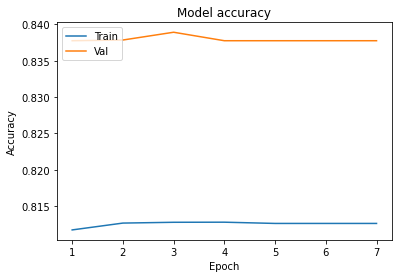

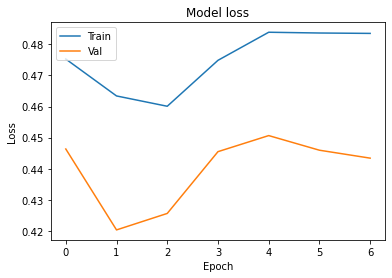

In [122]:
from matplotlib import pyplot as plt
epoch_range=range(1,early_stop_callback.stopped_epoch+1+1)
plt.plot(epoch_range,history.history['accuracy'])
plt.plot(epoch_range,history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Val'],loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Val'],loc='upper left')
plt.show()

In [123]:
X_val_l1.shape,X_val_l2.shape,df2_val_X.shape

((20579, 15), (20579, 15), (20579, 26))

In [124]:
y_pred = model.predict([X_val_l1,X_val_l2,df2_val_X])
y_pred.shape

(20579, 1)

In [125]:
y_val_eval = y_val.flatten()
y_pred_eval = y_pred.flatten()
y_val_eval.shape,y_pred_eval.shape

((20579,), (20579,))

In [126]:
from evaluation import BinClsEvaluation

bce = BinClsEvaluation(y_pred_eval,y_val_eval)

C:\Utilities\anaconda\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Utilities\anaconda\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Utilities\anaconda\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Utilities\anaconda\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1245: Undefi

In [127]:
bce.confusion_matrix(plot=False)


Cutoff = 0.0
--------Confusion Matrix-----------
          Predicted_1  Predicted_0
Actual_1            0        17240
Actual_0            0         3339
-----------------------------------
           Predicted_1  Predicted_0
Actual_1%          0.0          1.0
Actual_0%          0.0          1.0
-----------------------------------
          Predicted_1%  Predicted_0%
Actual_1           0.0          0.84
Actual_0           0.0          0.16
-------------Cost Matrix-----------
If model predict 1 and value 1, the gain is 1 x 3339 = 3339
If model predict 1 and value 0, the gain is -0.3 x 17240 = -5172.0
If model predict 0 and value 1, the gain is 0 x 0 = 0
If model predict 0 and value 0, the gain is 0 x 0 = 0
Average gain per record -0.09 x 20579 = -1833.0
--------------Metrics--------------
Accuracy: 0.16225278196219448
Precision: 0.16225278196219448
Recall: 1.0
F1-score: 0.27920394681829586
----------------------------------


Model: ROC AUC=0.500


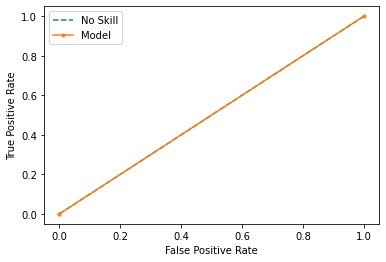

In [128]:
bce.roc_curve()